# FSRS4Anki v3.25.9 Optimizer

[![open in colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-spaced-repetition/fsrs4anki/blob/v3.25.9/fsrs4anki_optimizer.ipynb)

↑ Click the above button to open the optimizer on Google Colab.

> If you can't see the button and are located in the Chinese Mainland, please use a proxy or VPN.

Upload your **Anki Deck Package (.apkg)** file or **Anki Collection Package (.colpkg)** file on the `Left sidebar -> Files`, drag and drop your file in the current directory (not the `sample_data` directory). 

No need to include media. Need to include scheduling information. 

> If you use the latest version of Anki, please check the box `Support older Anki versions (slower/larger files)` when you export.

You can export it via `File -> Export...` or `Ctrl + E` in the main window of Anki.

Then replace the `filename` with yours in the next code cell. And set the `timezone` and `next_day_starts_at` which can be found in your preferences of Anki.

After that, just run all (`Runtime -> Run all` or `Ctrl + F9`) and wait for minutes. You can see the optimal parameters in section **2.3 Result**. Copy them, replace the parameters in `fsrs4anki_scheduler.js`, and paste them into the custom scheduling of your deck options (require Anki version >= 2.1.55).

**NOTE**: The default output is generated from my review logs. If you find the output is the same as mine, maybe your notebook hasn't run there.

**Contribute to SRS Research**: If you want to share your data with me, please fill this form: https://forms.gle/KaojsBbhMCytaA7h8

In [1]:
# Here are some settings that you need to replace before running this optimizer.

filename = "collection-2022-09-18@13-21-58.colpkg"
# If you upload deck file, replace it with your deck filename. E.g., ALL__Learning.apkg
# If you upload collection file, replace it with your colpgk filename. E.g., collection-2022-09-18@13-21-58.colpkg

# Replace it with your timezone. I'm in China, so I use Asia/Shanghai.
# You can find your timezone here: https://gist.github.com/heyalexej/8bf688fd67d7199be4a1682b3eec7568
timezone = 'Asia/Shanghai'

# Replace it with your Anki's setting in Preferences -> Scheduling.
next_day_starts_at = 4

# Replace it if you don't want the optimizer to use the review logs before a specific date.
revlog_start_date = "2006-10-05"


## 1 Build dataset

### 1.1 Extract Anki collection & deck file

In [2]:
%pip install -q fsrs4anki_optimizer==3.25.9
# for local development
# import os
# import sys
# sys.path.insert(0, os.path.abspath('./package/fsrs4anki_optimizer'))
import fsrs4anki_optimizer as optimizer
optimizer = optimizer.Optimizer()
optimizer.anki_extract(filename)

Deck file extracted successfully!


### 1.2 Create time-series feature & analysis

The following code cell will extract the review logs from your Anki collection and preprocess them to a trainset which is saved in [./revlog_history.tsv](./revlog_history.tsv).

The time-series features are important in optimizing the model's parameters. For more detail, please see my paper: https://www.maimemo.com/paper/

Then it will generate a concise analysis for your review logs. 

- The `r_history` is the history of ratings on each review. `3,3,3,1` means that you press `Good, Good, Good, Again`. It only contains the first rating for each card on the review date, i.e., when you press `Again` in review and  `Good` in relearning steps 10min later, only `Again` will be recorded.
- The `avg_interval` is the actual average interval after you rate your cards as the `r_history`. It could be longer than the interval given by Anki's built-in scheduler because you reviewed some overdue cards.
- The `avg_retention` is the average retention after you press as the `r_history`. `Again` counts as failed recall, and `Hard, Good and Easy` count as successful recall. Retention is the percentage of your successful recall.
- The `stability` is the estimated memory state variable, which is an approximate interval that leads to 90% retention.
- The `factor` is `stability / previous stability`.
- The `group_cnt` is the number of review logs that have the same `r_history`.

In [3]:
analysis = optimizer.create_time_series(timezone, revlog_start_date, next_day_starts_at)
print(analysis)

revlog.csv saved.
Trainset saved.
Retention calculated.


  0%|          | 0/26286 [00:00<?, ?it/s]

Stability calculated.


analysis:   0%|          | 0/489 [00:00<?, ?it/s]

Analysis saved!
1:again, 2:hard, 3:good, 4:easy
      r_history  avg_interval  avg_retention  stability  factor  group_cnt
              1           1.1          0.892        1.0     inf       2063
            1,3           3.1          0.920        4.0    4.00       1600
          1,3,3           7.1          0.910        7.9    1.98       1320
        1,3,3,3          16.6          0.862       10.8    1.37        986
      1,3,3,3,3          36.5          0.840       22.3    2.06        659
    1,3,3,3,3,3          77.0          0.861       36.4    1.63        358
  1,3,3,3,3,3,3         117.9          0.906       38.5    1.06        177
              2           1.0          0.902        1.1     inf        240
            2,3           3.5          0.946        8.2    7.45        201
          2,3,3          11.4          0.890        7.6    0.93        162
              3           1.1          0.977        5.0     inf       4669
            3,3           3.3          0.967       1

## 2 Optimize parameter

### 2.1 Define the model

FSRS is a time-series model for predicting memory states.

In [4]:
"""
w[0]: initial_stability_for_again_answer
w[1]: initial_stability_step_per_rating
w[2]: initial_difficulty_for_good_answer
w[3]: initial_difficulty_step_per_rating
w[4]: next_difficulty_step_per_rating
w[5]: next_difficulty_reversion_to_mean_speed (used to avoid ease hell)
w[6]: next_stability_factor_after_success
w[7]: next_stability_stabilization_decay_after_success
w[8]: next_stability_retrievability_gain_after_success
w[9]: next_stability_factor_after_failure
w[10]: next_stability_difficulty_decay_after_success
w[11]: next_stability_stability_gain_after_failure
w[12]: next_stability_retrievability_gain_after_failure
For more details about the parameters, please see: 
https://github.com/open-spaced-repetition/fsrs4anki/wiki/Free-Spaced-Repetition-Scheduler
"""
optimizer.define_model()
print(optimizer.init_w)

[1, 1, 5, -0.5, -0.5, 0.2, 1.4, -0.2, 0.8, 2, -0.2, 0.2, 1]


### 2.2 Train the model

The [./revlog_history.tsv](./revlog_history.tsv) generated before will be used for training the FSRS model.

  0%|          | 0/88151 [00:00<?, ?it/s]

Tensorized!
TRAIN: 57372 TEST: 30779
dataset built
Loss in trainset: 0.3341
Loss in testset: 0.3123


pre-train:   0%|          | 0/15276 [00:00<?, ?it/s]

w: [1.2588, 1.8518, 5.0, -0.5, -0.5, 0.2, 1.4, -0.2, 0.8, 2.0, -0.2, 0.2, 1.0]


train:   0%|          | 0/156840 [00:00<?, ?it/s]

Loss in trainset: 0.3316
Loss in testset: 0.3101
iteration: 15360
w: [1.2327, 2.0554, 5.2401, -1.3366, -1.1639, 0.05, 1.476, -0.15, 0.8888, 2.0642, -0.1568, 0.3447, 0.9199]
iteration: 30720
w: [1.2313, 2.0664, 5.3091, -1.8228, -1.4371, 0.05, 1.5368, -0.15, 0.9386, 2.0735, -0.172, 0.2893, 0.9297]
iteration: 46080
w: [1.2312, 2.067, 5.1756, -1.82, -1.5521, 0.05, 1.5302, -0.1804, 0.9387, 2.0758, -0.1855, 0.3562, 0.8933]
Loss in trainset: 0.3172
Loss in testset: 0.2975
iteration: 60984
w: [1.2312, 2.067, 5.1799, -1.9405, -1.6541, 0.05, 1.4829, -0.2316, 0.8883, 2.0124, -0.258, 0.3398, 0.8535]
iteration: 76344
w: [1.2312, 2.067, 4.9925, -1.8656, -1.6414, 0.05, 1.5321, -0.1741, 0.9293, 2.0305, -0.243, 0.2744, 0.8373]
iteration: 91704
w: [1.2312, 2.067, 5.0722, -2.0053, -1.7443, 0.05, 1.4873, -0.2288, 0.8849, 2.0728, -0.2052, 0.3092, 0.767]
Loss in trainset: 0.3169
Loss in testset: 0.2971
iteration: 106608
w: [1.2312, 2.067, 4.987, -1.9727, -1.7279, 0.05, 1.5134, -0.198, 0.9043, 2.0298, -0.251

pre-train:   0%|          | 0/22374 [00:00<?, ?it/s]

w: [2.0143, 2.047, 5.0, -0.5, -0.5, 0.2, 1.4, -0.2, 0.8, 2.0, -0.2, 0.2, 1.0]


train:   0%|          | 0/156714 [00:00<?, ?it/s]

Loss in trainset: 0.3172
Loss in testset: 0.3381
iteration: 15360
w: [2.1098, 2.1547, 5.1624, -1.3109, -1.2452, 0.05, 1.5603, -0.15, 0.9801, 2.0537, -0.1785, 0.2359, 1.1261]
iteration: 30720
w: [2.1147, 2.1603, 5.2114, -1.7705, -1.4815, 0.05, 1.5164, -0.1883, 0.9709, 2.0304, -0.2254, 0.3732, 1.0897]
iteration: 46080
w: [2.1149, 2.1605, 5.1015, -1.9801, -1.4999, 0.05, 1.4796, -0.1861, 0.9498, 1.9839, -0.283, 0.3439, 0.9421]
Loss in trainset: 0.3037
Loss in testset: 0.3244
iteration: 60942
w: [2.1149, 2.1605, 5.1075, -1.9231, -1.6885, 0.0635, 1.3861, -0.2296, 0.8601, 2.0228, -0.2517, 0.3458, 0.9562]
iteration: 76302
w: [2.1149, 2.1605, 5.024, -1.9369, -1.716, 0.05, 1.3839, -0.2055, 0.8635, 2.0164, -0.2617, 0.3731, 0.8707]
iteration: 91662
w: [2.1149, 2.1605, 4.8535, -1.8587, -1.6669, 0.05, 1.439, -0.1522, 0.9136, 2.0086, -0.2717, 0.3698, 0.809]
Loss in trainset: 0.3030
Loss in testset: 0.3238
iteration: 106524
w: [2.1149, 2.1605, 4.8535, -1.905, -1.6778, 0.05, 1.399, -0.1871, 0.8676, 2.0

pre-train:   0%|          | 0/20916 [00:00<?, ?it/s]

w: [1.2804, 1.8287, 5.0, -0.5, -0.5, 0.2, 1.4, -0.2, 0.8, 2.0, -0.2, 0.2, 1.0]


train:   0%|          | 0/156786 [00:00<?, ?it/s]

Loss in trainset: 0.3233
Loss in testset: 0.3258
iteration: 15360
w: [1.2103, 1.9125, 5.2223, -1.3239, -1.3125, 0.05, 1.5385, -0.1749, 0.9212, 2.0346, -0.1624, 0.3354, 1.0593]
iteration: 30720
w: [1.2066, 1.9168, 5.2443, -1.6266, -1.5494, 0.05, 1.4753, -0.1821, 0.8804, 1.9437, -0.264, 0.3369, 0.7392]
iteration: 46080
w: [1.2065, 1.917, 5.1167, -1.8355, -1.5635, 0.05, 1.4941, -0.1721, 0.8861, 1.9933, -0.2259, 0.3439, 0.6005]
Loss in trainset: 0.3098
Loss in testset: 0.3112
iteration: 60966
w: [1.2065, 1.917, 5.0007, -1.6979, -1.6784, 0.05, 1.4608, -0.1968, 0.8441, 2.0375, -0.1941, 0.3672, 0.5359]
iteration: 76326
w: [1.2065, 1.917, 4.9066, -1.7258, -1.6968, 0.05, 1.4394, -0.2106, 0.8168, 2.0294, -0.2062, 0.3273, 0.547]
iteration: 91686
w: [1.2065, 1.917, 4.8547, -1.8015, -1.7653, 0.05, 1.4972, -0.158, 0.8681, 2.0529, -0.1808, 0.3349, 0.5057]
Loss in trainset: 0.3095
Loss in testset: 0.3109
iteration: 106572
w: [1.2065, 1.917, 4.8316, -1.859, -1.766, 0.0548, 1.5013, -0.167, 0.8685, 2.039

[<Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>]

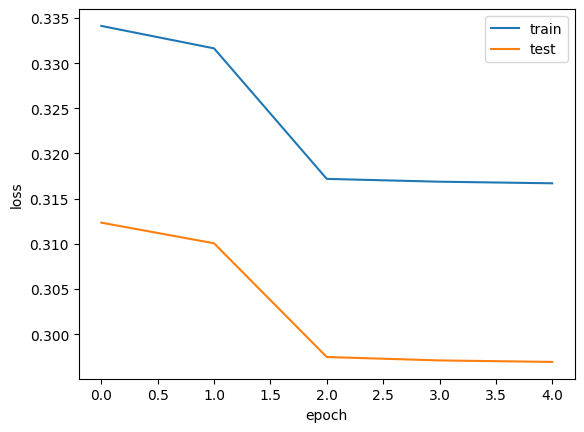

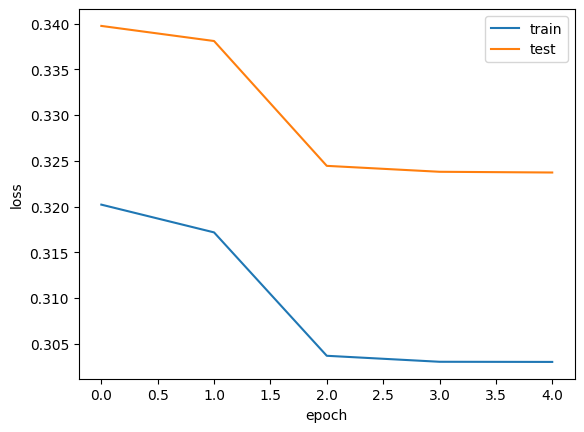

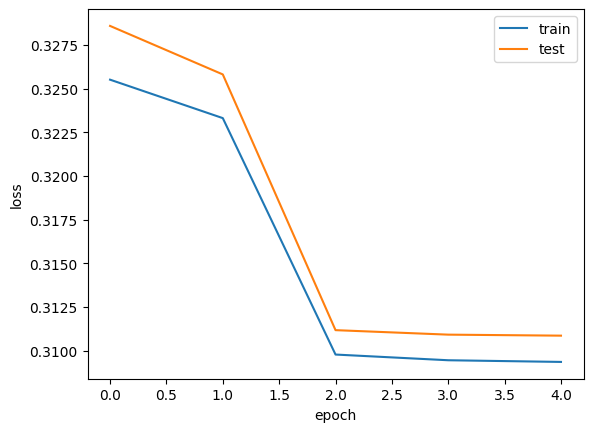

In [5]:
optimizer.train()

### 2.3 Result

Copy the optimal parameters for FSRS for you in the output of next code cell after running.

In [6]:
print(optimizer.w)

[1.5175, 2.0482, 4.8809, -1.9485, -1.7534, 0.05, 1.4583, -0.1878, 0.8626, 2.0418, -0.2238, 0.3652, 0.6071]


### 2.4 Preview

You can see the memory states and intervals generated by FSRS as if you press the good in each review at the due date scheduled by FSRS.

In [7]:
requestRetention = 0.9  # recommended setting: 0.8 ~ 0.9

preview = optimizer.preview(requestRetention)
print(preview)

1:again, 2:hard, 3:good, 4:easy

first rating: 1
rating history: 1,3,3,3,3,3,3,3,3,3,3
interval history: 0d,2d,3d,6d,10d,18d,1.0m,1.7m,2.7m,4.4m,6.8m
difficulty history: 0,8.8,8.6,8.4,8.2,8.1,7.9,7.7,7.6,7.5,7.3

first rating: 2
rating history: 2,3,3,3,3,3,3,3,3,3,3
interval history: 0d,4d,9d,19d,1.3m,2.4m,4.3m,7.4m,1.0y,1.6y,2.6y
difficulty history: 0,6.8,6.7,6.6,6.6,6.5,6.4,6.3,6.2,6.2,6.1

first rating: 3
rating history: 3,3,3,3,3,3,3,3,3,3,3
interval history: 0d,6d,16d,1.3m,2.8m,5.7m,10.8m,1.6y,2.7y,4.5y,7.2y
difficulty history: 0,4.9,4.9,4.9,4.9,4.9,4.9,4.9,4.9,4.9,4.9

first rating: 4
rating history: 4,3,3,3,3,3,3,3,3,3,3
interval history: 0d,8d,24d,2.2m,5.1m,11.1m,1.8y,3.4y,6.0y,10.0y,16.1y
difficulty history: 0,2.9,3.0,3.1,3.2,3.3,3.4,3.4,3.5,3.6,3.7



You can change the `test_rating_sequence` to see the scheduling intervals in different ratings.

In [8]:
test_rating_sequence = "3,3,3,3,3,1,1,3,3,3,3,3"
requestRetention = 0.9  # recommended setting: 0.8 ~ 0.9
easyBonus = 1.3
hardInterval = 1.2

preview_sequence = optimizer.preview_sequence(test_rating_sequence, requestRetention, easyBonus, hardInterval)
print(preview_sequence)

tensor([5.6139, 4.8809])
tensor([15.8899,  4.8809])
tensor([38.4434,  4.8809])
tensor([83.8271,  4.8809])
tensor([170.4739,   4.8809])
tensor([8.8441, 8.2124])
tensor([ 2.8757, 10.0000])
tensor([4.0717, 9.7440])
tensor([5.8560, 9.5009])
tensor([8.7398, 9.2699])
tensor([13.2609,  9.0504])
tensor([19.9486,  8.8420])
rating history: 3,3,3,3,3,1,1,3,3,3,3,3
interval history: 0,6,16,38,84,170,9,3,4,6,9,13,20
difficulty history: 0,4.9,4.9,4.9,4.9,4.9,8.2,10.0,9.7,9.5,9.3,9.1,8.8


### 2.5 Predict memory states and distribution of difficulty

Predict memory states for each review group and save them in [./prediction.tsv](./prediction.tsv).

Meanwhile, it will count the distribution of difficulty.

In [9]:
optimizer.predict_memory_states()

prediction.tsv saved.


difficulty
1     0.005491
2     0.012796
3     0.129596
4     0.004333
5     0.231898
6     0.034611
7     0.039069
8     0.113566
9     0.162460
10    0.266180
Name: count, dtype: float64

## 3 Optimize retention to minimize the time of reviews

Calculate the optimal retention to minimize the time for long-term memory consolidation. It is an experimental feature. You can use the simulator to get more accurate results:

https://github.com/open-spaced-repetition/fsrs4anki/blob/main/fsrs4anki_simulator.ipynb

average time for failed cards: 33.7s
average time for recalled cards: 10.6s
terminal stability:  1962.85


find optimal retention:   0%|          | 0/15 [00:00<?, ?it/s]

expected_time.csv saved.

-----suggested retention (experimental): 0.87-----


(<Figure size 640x480 with 1 Axes>,)

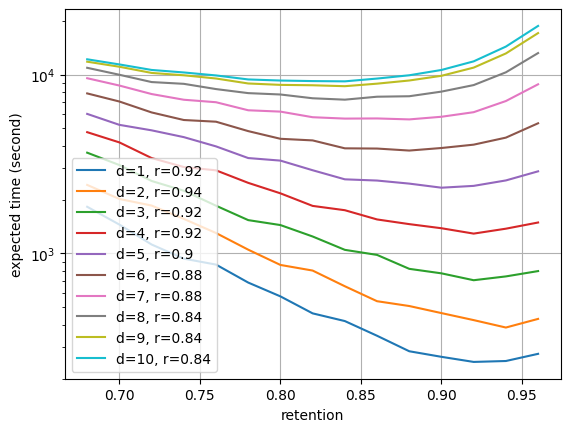

In [10]:
optimizer.find_optimal_retention()

## 4 Evaluate the model

### 4.1 Loss

Evaluate the model with the log loss. It will compare the log loss between initial model and trained model.

And it will predict the stability, difficulty and retrievability for each revlog in [./evaluation.tsv](./evaluation.tsv).

In [11]:
loss_before, loss_after = optimizer.evaluate()
print(f"Loss before training: {loss_before:.4f}")
print(f"Loss after training: {loss_after:.4f}")

Loss before training: 0.3265
Loss after training: 0.3097


### 4.2 Calibration graph

1. FSRS predicts the stability and retention for each review.
2. Reviews are grouped into 40 bins according to their predicted retention.
3. Count the true retention of each bin.
4. Plot (predicted retention, true retention) in the line graph.
5. Plot (predicted retention, size of bin) in the bar graph.
6. Combine these graphs to create the calibration graph.

Ideally, the blue line should be aligned with the orange one. If the blue line is higher than the orange line, the FSRS underestimates the retention. When the size of reviews within a bin is small, actual retention may deviate largely, which is normal.

R-squared (aka the coefficient of determination), is the proportion of the variation in the dependent variable that is predictable from the independent variable(s). The higher the R-squared, the better the model fits your data. For details, please see https://en.wikipedia.org/wiki/Coefficient_of_determination

RMSE (root mean squared error) is the square root of the average of squared differences between prediction and actual observation. The lower the RMSE, the better the model fits your data. For details, please see https://en.wikipedia.org/wiki/Root-mean-square_deviation

R-squared: 0.9290
RMSE: 0.0188
[0.09840693 0.89082522]


(<Figure size 640x480 with 2 Axes>,
 <Figure size 640x480 with 2 Axes>,
 <Figure size 640x480 with 2 Axes>)

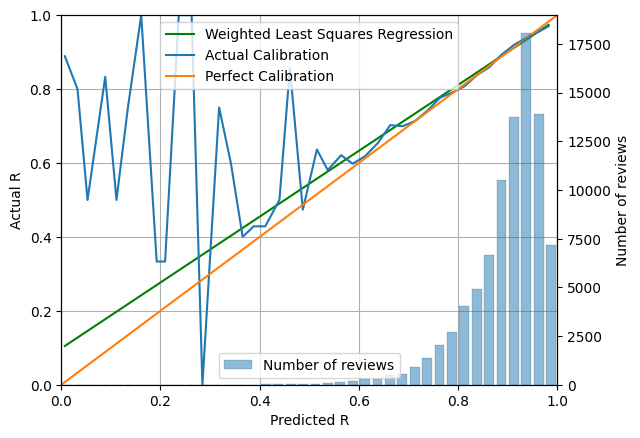

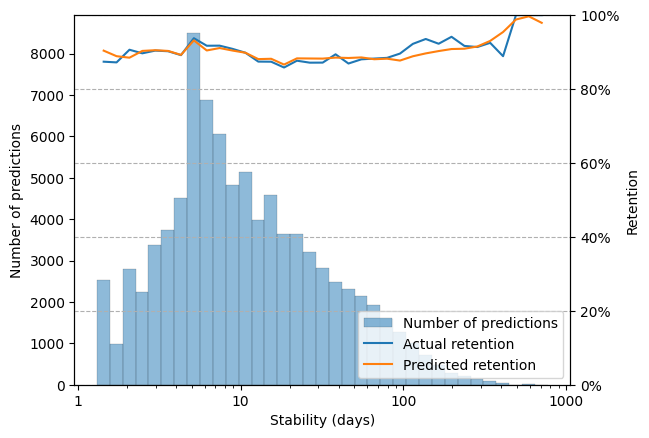

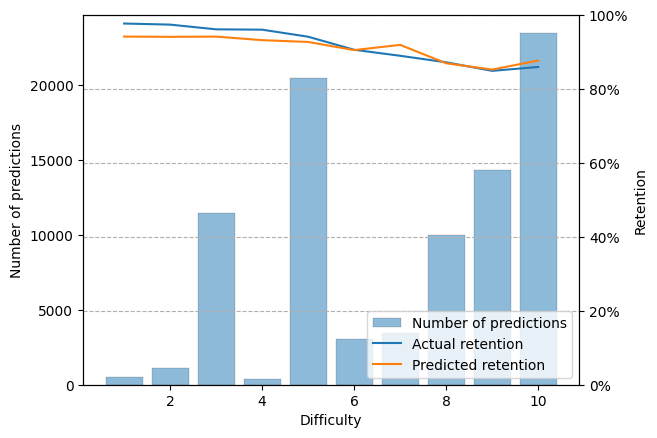

In [12]:
optimizer.calibration_graph()

### 4.3 Cumulative B-W Metric

For details about Cumulative B-W Metric, please see: [Algorithm SM-17 as a good predictor - supermemo.guru](https://supermemo.guru/wiki/Universal_metric_for_cross-comparison_of_spaced_repetition_algorithms#Algorithm_SM-17_as_a_good_predictor)

In [13]:
optimizer.bw_matrix()

d_bin,3,5,6,7,8,9,10
s_bin,,,,,,,
1.400000,,,,,,2.59%,2.92%
1.960000,,,,,3.29%,-4.90%,0.01%
2.740000,,,,5.14%,-1.44%,0.13%,0.01%
3.840000,,,,-1.03%,-1.95%,-3.87%,1.01%
5.380000,,-1.05%,,-0.59%,-1.80%,-2.60%,0.23%
7.530000,-1.41%,-1.47%,-3.05%,0.72%,-0.56%,-2.16%,2.32%
10.540000,-1.51%,-2.19%,,5.60%,-0.33%,1.66%,5.02%
14.760000,-1.95%,-0.91%,0.90%,3.48%,0.64%,1.92%,9.03%
20.660000,-2.47%,-1.75%,0.55%,-0.03%,2.18%,2.94%,8.95%


### 4.4 Compare with SM-2

For details about universal metric, please see: [Algorithmic contest: SuperMemo 2 vs. SuperMemo 17 - supermemo.guru](https://supermemo.guru/wiki/Universal_metric_for_cross-comparison_of_spaced_repetition_algorithms#Algorithmic_contest:_SuperMemo_2_vs._SuperMemo_17)

Loss of SM-2: 0.3915
R-squared: -6.8749
RMSE: 0.1527
[0.68927589 0.25115013]
Universal Metric of FSRS: 0.0123
Universal Metric of SM2: 0.0833


(<Figure size 640x480 with 2 Axes>, <Figure size 600x600 with 1 Axes>)

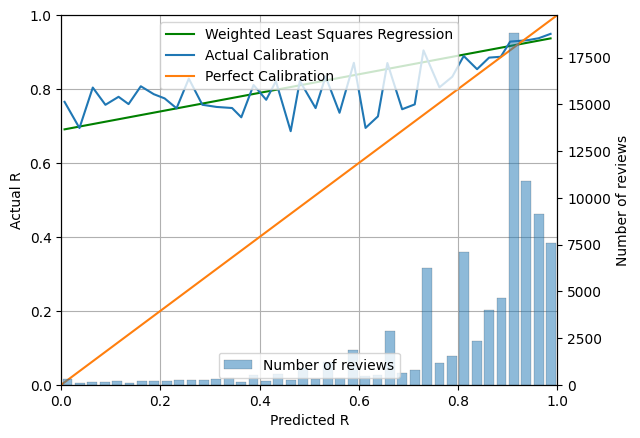

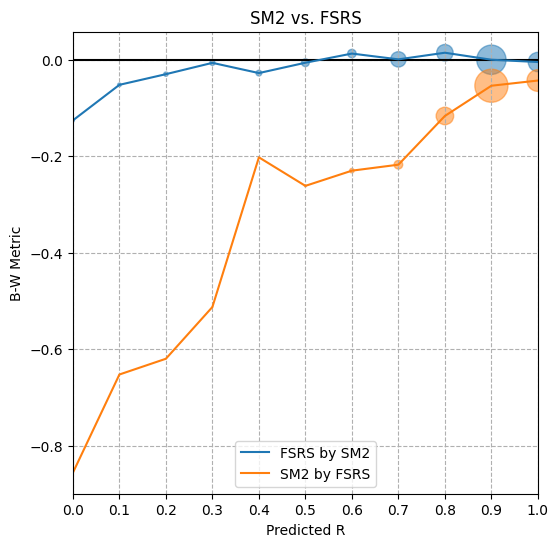

In [14]:
optimizer.compare_with_sm2()